# process image frames
###Grant Zhao 26056379

### the goal of this notebook is to process the frames using tensorflow object detection API's pretrained models and take advantge of google colab's computing power. Bounding box information will be stored in a separte folder on google drive. To reproduce the result you will have to use colab, mount your google drive onto this notebook, then create the corresponding folders on your drive to hold the input frames and out put bounding boxes

# Download tensorFlow object detecion API
**Object Detection API configuration**: In this step, the model for object detection is downloaded, also some copying and deletion of references are done to leave the whole scheme configured.

In [0]:
!git clone https://github.com/tensorflow/models.git
!apt-get -qq install libprotobuf-java protobuf-compiler
!protoc ./models/research/object_detection/protos/string_int_label_map.proto --python_out=.
!cp -R models/research/object_detection/ object_detection/
!rm -rf models

Cloning into 'models'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 25101 (delta 5), reused 7 (delta 5), pack-reused 25087
Receiving objects: 100% (25101/25101), 507.62 MiB | 28.56 MiB/s, done.
Resolving deltas: 100% (14974/14974), done.
Checking out files: 100% (2862/2862), done.


# Imports

mount the google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pandas as pd
from scipy.spatial.distance import euclidean
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt

from PIL import Image

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [0]:
%matplotlib inline

# Function to download and load model from TensorFlow model zoo
**Configuration** of the model to use, path to the frozen inference graph and extra config elements for the Object detection API implementation.

In [0]:
def prepare_model(MODEL_NAME):
  # What model to download.
  # MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
  
  # model with more accurancy but up to you use a diferent model
  #MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_coco_2018_01_28'
  
  MODEL_FILE = MODEL_NAME + '.tar.gz'
  DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
  
  # Path to frozen detection graph. This is the actual model that is used for the object detection.
  PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
  
  # List of the strings that is used to add correct label for each box.
  PATH_TO_LABELS = os.path.join('object_detection/data', 'mscoco_label_map.pbtxt')
  
  NUM_CLASSES = 90
  
  opener = urllib.request.URLopener()
  opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
  tar_file = tarfile.open(MODEL_FILE)
  for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
      tar_file.extract(file, os.getcwd())
      
  detection_graph = tf.Graph()
  with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
      serialized_graph = fid.read()
      od_graph_def.ParseFromString(serialized_graph)
      tf.import_graph_def(od_graph_def, name='')
      
  label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
  categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
  category_index = label_map_util.create_category_index(categories)
  return detection_graph,categories,category_index

In [0]:
detection_graph,categories,category_index = prepare_model('faster_rcnn_inception_resnet_v2_atrous_coco_2018_01_28')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  """Entry point for launching an IPython kernel.


In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

the path to the directory that holds the frames on the drive

In [0]:
PATH_TO_TEST_IMAGES_DIR = 'drive/My Drive/pets_frames'
frame_number = 300
# TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'frame_{0:04}.jpg'.format(i)) for i in range(frame_number) ]
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'frame_{0:04}.jpg'.format(i)) for i in range(295,frame_number) ]
IMAGE_SIZE = (12, 8)

In [0]:
def filter_bounding_box(boundingbox,label):
    out = []
    for i in range(boundingbox.shape[1]):
        if label[i] == 1:
          curr = boundingbox[0][i]
          if np.sum(curr) >2:
              if len(out) ==0 :
                  out.append(curr.copy())
              else:
                  unique = 1
                  for j in range(len(out)):
                      if euclidean(curr[0:2],out[j][0:2])+euclidean(curr[2:],out[j][2:])<4:
                          unique = 0
                          break
                  if unique ==1:
                      out.append(curr.copy())
    return np.array(out)

output folder to hold bounding box information

In [0]:
OUTPUT_DIR = 'drive/My Drive/detecor_out_hard'

In [0]:
def label_frames(show_detection = 0):
  with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
      detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      for im in range(len(TEST_IMAGE_PATHS)):
        image_path = TEST_IMAGE_PATHS[im]
        image = Image.open(image_path)
        image_np = load_image_into_numpy_array(image)
        image_np_expanded = np.expand_dims(image_np, axis=0)
        (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})
        if show_detection == 1:
          vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
              np.squeeze(scores),
              category_index,
              use_normalized_coordinates=True,
              line_thickness=4)
          plt.figure(figsize=IMAGE_SIZE)
          plt.imshow(image_np)
        height = image_np.shape[0]
        width = image_np.shape[1]
        boxes[0,:,0] *= height
        boxes[0,:,1] *= width
        boxes[0,:,2] *= height
        boxes[0,:,3] *= width
        boxes = filter_bounding_box(boxes.astype(np.int32),np.squeeze(classes))
        boxes= np.squeeze(boxes)
        out = np.zeros(boxes.shape)
        out[:,3] = boxes[:,2]-boxes[:,0]
        out[:,2] = boxes[:,3]-boxes[:,1]
        out[:,1] = boxes[:,0]
        out[:,0] = boxes[:,1]
        out= pd.DataFrame(out.astype('int'))
        out.to_csv(OUTPUT_DIR+'/frame_{0:04}.txt'.format(im),sep=' ',header=False,index=False)
        
       

# Labeling the Frames

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  """Entry point for launching an IPython kernel.


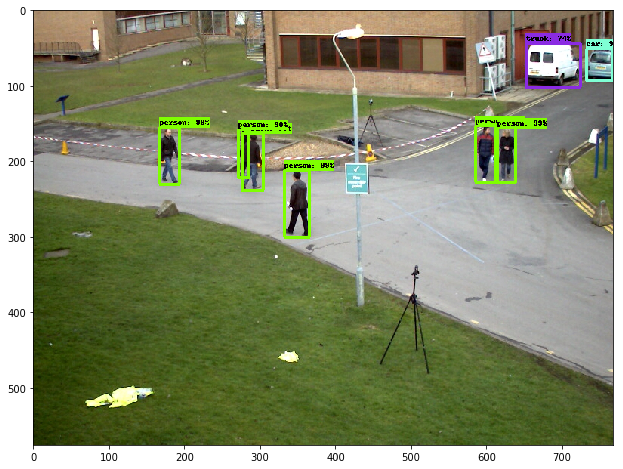

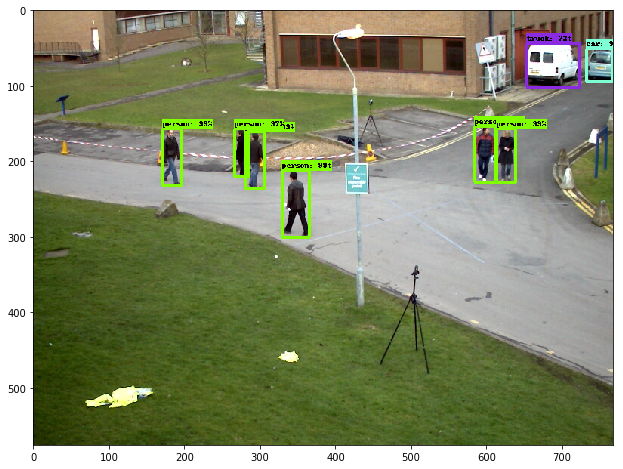

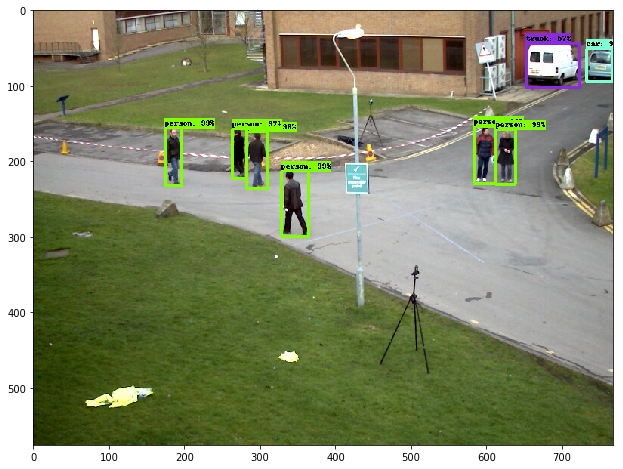

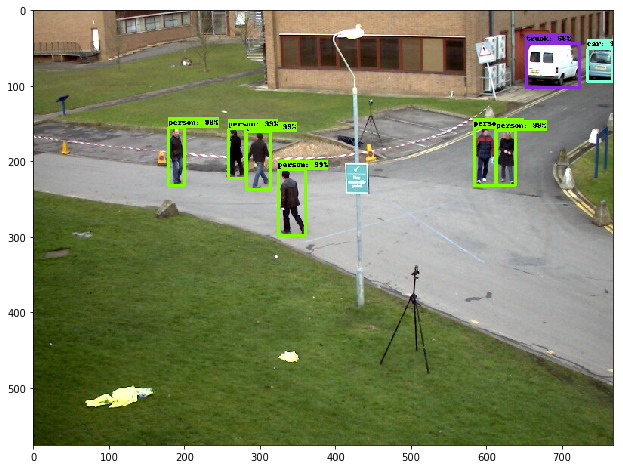

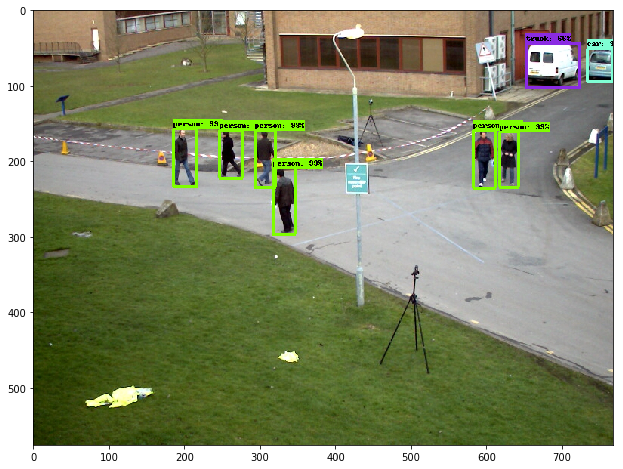

In [0]:
detection_graph,categories,category_index = prepare_model('faster_rcnn_nas_lowproposals_coco_2018_01_28')
label_frames(1)

In [0]:
detection_graph,categories,category_index = prepare_model('faster_rcnn_nas_coco_2018_01_28')
label_frames(1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  """Entry point for launching an IPython kernel.


KeyboardInterrupt: ignored